<a href="https://colab.research.google.com/github/dtabuena/EphysLib/blob/main/Synapse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
'Get Standard Modules'

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import os
from scipy.signal import butter,filtfilt
from tqdm import tqdm
import warnings
from IPython.display import clear_output
from datetime import datetime
import sys
import warnings
import shutil
from google.colab import files
warnings.filterwarnings('ignore')
np.set_printoptions(threshold=sys.maxsize)
clear_output(wait=False)



!pip install openpyxl
!pip install XlsxWriter


'''Get Repositories'''
try: shutil.rmtree('/content/EphysLib')
except: None

"run dtabuena's ephys notebooks"
!git clone https://github.com/dtabuena/EphysLib
to_import = [
            'ABF_Quality_Control.ipynb',
            'Basic_Ephys.ipynb',
            'Simple_ABF_tools.ipynb',
            'fun_math.ipynb',
            'importing_abfs_from_dropbox.ipynb',
            'QC_recoding_dataframe.ipynb',
            'Analyzers/input_resistance_analyzer.ipynb',
            'Analyzers/gain_analyzer.ipynb',
            'Analyzers/latencey_analyzer.ipynb',
            'Analyzers/IV_analyzer.ipynb',
            'Analyzers/Vm_analyzer.ipynb',
            'Analyzers/membrane_analyzer.ipynb',
            'Analyzers/rheobase_analyzer.ipynb',
            'Ephys_wrapper.ipynb',
            ]
for i in to_import:
    f = '/content/EphysLib/' + i
    %run $f




Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.7/152.7 kB 1.3 MB/s eta 0:00:00
Cloning into 'EphysLib'...
remote: Enumerating objects: 1074, done.
remote: Counting objects: 100% (451/451), done.
remote: Compressing objects: 100% (258/258), done.
remote: Total 1074 (delta 329), reused 230 (delta 193), pack-reused 623
Receiving objects: 100% (1074/1074), 17.23 MiB | 12.44 MiB/s, done.
Resolving deltas: 100% (706/706), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.2/53.2 kB 2.1 MB/s eta 0:00:00


In [2]:
##### Setup Protocol List
VC_prot = ['VC - MemTest-10ms-160ms',
           'VC - Multi IV - 150ms',]
IC_prot = ['IC - Gain - D20pA',
           'IC - Gain - D50pA',
           'IC - Rheobase',
           'IC - R input',
           'IC - Latentcy 800pA-1s'
           'VC - 3min GapFree',
           'I0 - 3min GapFree']

In [3]:
dataset = {'data_name': 'Today',
           'data_source': "https://www.dropbox.com/sh/wnbpd76u1v28qnz/AADD0BDu0BF81SAlN4Q6QxFea?dl=0",
           'file_naming_scheme': ['Rec_date','GenoType','Sex','Age','Slice_Num','Cell_num','Cell_Type'],
           }
           
data_name = dataset['data_name']
data_source = dataset['data_source']
file_naming_scheme = dataset['file_naming_scheme']

''' Gather and Catalog Source Data'''
file_loc = get_drobox_folder(data_source, 'my_ephys_data_' + data_name)
clear_output(wait=False)   
abf_recordings_df, protocol_set = catalogue_recs(file_loc,file_naming_scheme)
print(protocol_set)

['IC - Rheobase', 'VC - MemTest-10ms-160ms', 'IC - Latentcy 800pA-1s', 'IC - R input', 'VC - 3min GapFree', 'VC - Multi IV - 150ms', 'VC - Multi IV - 450ms', 'I0 - 3min GapFree', 'IC - Gain - D10pA', 'VC - 70mV - 3min GapFree']


In [4]:

display(abf_recordings_df.columns)

Index(['Recording_name', 'cell_id', 'Rec_date', 'GenoType', 'Sex', 'Age',
       'Slice_Num', 'Cell_num', 'Cell_Type', 'protocol', 'abf_timestamp',
       'channelList'],
      dtype='object')

In [5]:
synapse = ['VC - 70mV - 3min GapFree', 'VC - 3min GapFree']
# for r in abf_recordings_df.index:
#     if abf_recordings_df.loc[r,'protocol'] in synapse:
#         print(r)
        
abf_list = [r for r in abf_recordings_df.index if abf_recordings_df.loc[r,'protocol'] in synapse]


my_ephys_data_Today/2023x04x12_E4KI_F_P236_s001_c003_DG_0003.abf
-4sd: -5.1083002849743


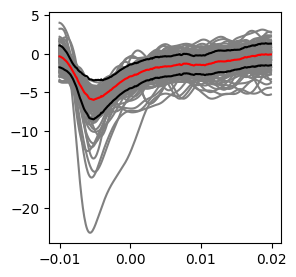

4sd: 5.1083002849743


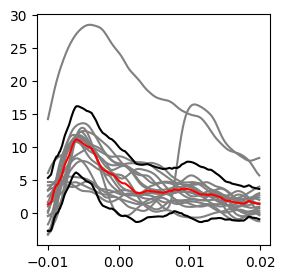

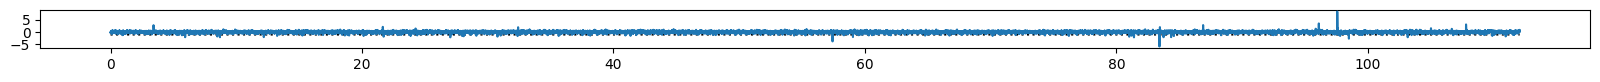

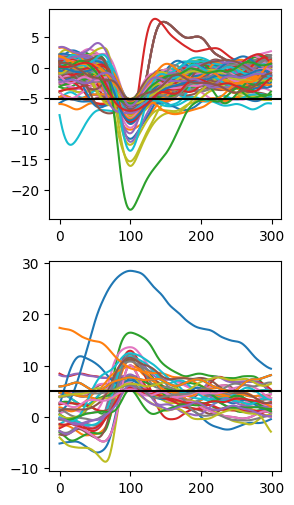

In [6]:
import scipy as sc




def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = np.min([1-1/fs,highcut / nyq])
    b, a = sc.signal.butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=2):

    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    data = sc.signal.filtfilt(b, a, data)

    b_notch,a_notch = sc.signal.iirnotch(50, 20, fs=fs)
    data = sc.signal.filtfilt(a_notch, a_notch, data)
    data = data-np.mean(data)
    return data

def filter_for_PSCs(abf, lowcut, highcut,):
    time = abf.sweepX
    response = abf.sweepY
    holding = abf.sweepC
    fs=abf.sampleRate
    response_f1 = butter_bandpass_filter(response, lowcut, highcut, fs  ) 
    response_f2 = butter_bandpass_filter(response, .01, 5000, fs  )
    
    # fig,ax = plt.subplots(1,figsize=[16,3])
    # ax.plot(time,response_f2,'k')
    # ax.plot(time,response_f1,'r')
    x0 = np.random.choice(time,1)
    x0 = 25.25
    dur = 3
    xlims = x0 +np.array([0,dur])
    # ax.set_xlim(xlims)
    # ax.set_ylim([-30,10])

    return response_f1




def make_template(stack_np,to_plot=False,k=1):
    U, S, Vh = sc.linalg.svd(stack_np,full_matrices=False)
    u_k, s_k, vh_k = sc.sparse.linalg.svds(stack_np,k=k)
    stack_reduced = u_k @ np.diag(s_k) @ vh_k
    template = np.median(stack_reduced,axis=0)
    if to_plot:
        fig,ax =plt.subplots(1,figsize=[3,3])
        ax.plot((np.diag(s_k) @ vh_k).T ,'grey')
        ax_right = ax.twinx()
        ax_right.plot(template,'red')
    scaled_template = template/np.sum(template)*np.sign(np.sum(template))
    return template, scaled_template


def find_events(response_f1,fs, sd_thresh = 5,cool_down_time=0,to_plot= True,window=[-0.015,0.02]):
    sd = np.std(response_f1)
    print(str(sd_thresh)+'sd:',sd*sd_thresh)
    cool_down_idx = cool_down_time*fs


    if sd_thresh>0: is_event= response_f1 > sd*sd_thresh
    if sd_thresh<0: is_event= response_f1 < sd*sd_thresh

    event_start = np.diff(is_event,prepend=0)>0
    starts = np.where(event_start)[0]



    x0t = window[0]
    x1t = window[1]
    x0n = x0t*fs
    x1n = x1t*fs

    
    time_wind = np.arange(x0t,x1t,1/fs)
    ind_range = np.arange(x0n,x1n,dtype=int)    
    stack_np, starts = window_stack(response_f1,[x0n,x1n],starts)

    is_upward = np.sum(stack_np.flatten())>0
    

    if is_upward: extrema = np.max(stack_np,axis=1)
    if not is_upward: extrema = np.min(stack_np,axis=1)
    shift = np.array([int(np.where(extrema[r]==stack_np[r,:])[0][0]+x0n) for r in range(stack_np.shape[0])])
    stack_np,_ = window_stack(response_f1,[x0n,x1n],starts+shift)

    return stack_np, sd*sd_thresh

def window_stack(trace,ind_range,inds):
    window = np.arange(ind_range[0],ind_range[1],dtype='int')
    stack = []
    valid_ind=[]
    for i in inds:
        indx_wind = i + window
        try:
            i_trace = trace[indx_wind]
            stack.append(i_trace)
            valid_ind.append(i)
        except: None    
    stack = np.stack(stack)
    return stack, valid_ind



def search_for_template(trace,abf, template,corr_thresh=3,window=[-0.015,0.02]):
    fs=abf.sampleRate

    fig,ax = plt.subplots(1,figsize=[3,3])
    corr = np.correlate(trace , template, mode='same')
    is_corr_event = corr>corr_thresh
    is_corr_event = np.diff(is_corr_event,prepend=0)>0
    event_inds = np.where(is_corr_event)[0]
    t_inds = abf.sweepX[event_inds]

    time_wind = np.arange(window[0],window[1],1/fs)    
    corr_stack,_ =  window_stack(corr,[window[0]*fs,window[1]*fs],event_inds)
    max_corr = np.max(corr_stack,axis=1)
    for r in range(len(max_corr)):
        shift = np.where(corr_stack[r,:] == max_corr[r] )[0][0]
        event_inds[r] = event_inds[r] + (shift + window[0]*fs) 
        
    stack,_ = window_stack(trace,[window[0]*fs,window[1]*fs],event_inds)
    epsc_mean = np.median(stack,axis=0)
    epsc_std = np.std(stack,axis=0)
    ax.plot(time_wind,stack.T,'grey')
    ax.plot(time_wind,epsc_mean,color='red')
    ax.plot(time_wind,epsc_mean+epsc_std,color='k')
    ax.plot(time_wind,epsc_mean-epsc_std,color='k')
    plt.show()

    event_times = abf.sweepX[event_inds]
    return {'stack':stack, 'epsc_mean':epsc_mean, 'epsc_std':epsc_std,'event_inds':event_inds,'event_times':event_times}




def plot_raw(abf,t_range='all',num_rows=80,raster_t=[]):
    raster_t = np.array(raster_t)    
    if 'all' in t_range:
        t_range= [0, abf.sweepX[-1]]
    response_f1 = filter_for_PSCs(abf, lowcut = .5, highcut = 100)

    trim_resp = response_f1[np.logical_and(abf.sweepX>t_range[0], abf.sweepX<t_range[1])]
    trim_time = abf.sweepX[np.logical_and(abf.sweepX>t_range[0], abf.sweepX<t_range[1])]
    trim_time =trim_time-trim_time[0]
    sd=np.std(trim_resp)
    norm_resp = trim_resp/sd/3

    fig,ax=plt.subplots(1,figsize=(20,0.25*num_rows))
    row_len = int(len(trim_resp)/num_rows)
    row_ind = np.arange(row_len)
    t_wind = np.arange(row_len)/abf.sampleRate
    # try:
    offset_amp = 1


    ##### Convert trace to mat(rows,T)

    for r in np.arange(num_rows):
        offset = -r*offset_amp
        y_ind = row_len*(r+1)  + row_ind
        is_valid = y_ind<len(norm_resp)
        y_ind=y_ind[is_valid]     
        y_wind = norm_resp[y_ind] + offset
        ax.plot(t_wind[is_valid],y_wind,zorder=5)
        ax.plot(t_wind, offset * np.ones_like(t_wind),':k' ,zorder=-5)

        x_wind = abf.sweepX[y_ind]
        for x in x_wind:
            if len(raster_t)==len(raster_t.flatten()):
                raster_t = np.array([raster_t])
            num_rasters = len(raster_t)
            for rast_i in range(num_rasters):
                rast = raster_t[rast_i]
                color = matplotlib.cm.coolwarm(rast_i/num_rasters*255)
                # print("color",color)
                if x in rast:
                    x_ind = np.where(x_wind==x)[0][0]                    
                    ax.scatter(t_wind[x_ind],offset+offset_amp/2,color=color,marker = '|')
                
    return None


def psc_wrapper(abf,sd_thresh=[-4,4],window=[-0.015,0.02],lowcut = .5, highcut = 1000,to_plot=False):
    exit_results ={}
    response_f1 = filter_for_PSCs(abf, lowcut = lowcut, highcut = highcut)
    
    exit_stack, ex_I_thresh = find_events(response_f1, abf.sampleRate, np.min(sd_thresh),window=window)
    _,exit_template=make_template(exit_stack,to_plot=False,k=5)
    exit_results=search_for_template(response_f1,abf, exit_template, corr_thresh=3,window=window)
    
    inhib_stack, inh_I_thresh = find_events(response_f1, abf.sampleRate, np.max(sd_thresh),window=window)
    _,inhib_template=make_template(inhib_stack,to_plot=False,k=5)
    inhib_results=search_for_template(response_f1,abf, inhib_template, corr_thresh=3,window=window)
   
    plot_raw(abf,num_rows=2,raster_t = [exit_results['event_times'],inhib_results['event_times']])        

    to_plot=True
    if to_plot:
        fig,ax = plt.subplots(2,1,figsize=[3,6])
        ax[0].plot(exit_stack.T)
        ax[0].axhline(ex_I_thresh,color='k')
        ax[1].plot(inhib_stack.T)
        ax[1].axhline(inh_I_thresh,color='k')

    return exit_results

to_plot= True
my_abf = abf_list[6]
print(my_abf)
abf=abf_or_name(my_abf)


exit_results = psc_wrapper(abf,sd_thresh=[-4,4],window=[-.01,0.02],lowcut = .5, highcut = 200,to_plot=True)





# time = abf.sweepX
# response = abf.sweepY
# holding = abf.sweepC
# fs=abf.sampleRate





# response_f1 = filter_for_PSCs(abf, lowcut = .5, highcut = 1000)
# stack_np = find_events(response_f1,fs, sd_thresh = 4,cool_down_time = 0.005 , to_plot= True)
# _,template = make_template(stack_np)
# res = search_for_template(response_f1, -template, corr_thresh=3)

